In [1]:
using RCall
figsize(;width,height) =
    RCall.ijulia_setdevice(MIME("image/svg+xml"), width=width, height=height)
R"
require(tidyverse)
"

┌ Warning: RCall.jl: Loading required package: tidyverse
│ ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
│ ✔ ggplot2 3.4.0     ✔ purrr   1.0.1
│ ✔ tibble  3.1.8     ✔ dplyr   1.1.0
│ ✔ tidyr   1.3.0     ✔ stringr 1.5.0
│ ✔ readr   2.1.3     ✔ forcats 1.0.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


RObject{LglSxp}
[1] TRUE


# Epidemic model with Heterogeneity
We assume our epidemic dynamic follows([Tkachenko et al.](https://www.pnas.org/doi/10.1073/pnas.2015972118))
$$
\def\d{\,{\rm d}}
\def\D#1#2{\frac{\d #1}{\d #2}}
\def\<{\left<}
\def\>{\right>}
\def\[{\left[}
\def\]{\right]}
\def\{{\left\{}
\def\}{\right\}}
\def\({\left(}
\def\){\right)}
\def\R{{\cal R}}
$$
$$
\begin{align}
\D{S_a(t)}t & = - \beta a S_a J = - j_a \\
J(t)
& = \int \R_a {\int^t K(s) j_a(t-s) \d s} f(a) \d a \\
& = \<\R_a \[K, j_a\]\> \\
& = \[K, \R_e J\]
\end{align}
$$
where
- susceptible rate $S_a(t)$ with relative susceptibility $a \sim f(a)$,
- force of infection $J(t) = \<j_a(t)\>$,
- base infectivity $\beta$,
- generation interval distribution([Sender et al.](https://elifesciences.org/articles/79134))
$$K(s) \sim \text{LogNormal}\(\text{median}=7.9, \text{mean}=9.7\),$$
- reproduction number(infectivity) $\R_a$ of sub-population $S_a$, and
- effective reproduction number $\R_e(t) = \beta \<a \R_a S_a(t)\>$.

To simulate this dynamcis in an agent-based manner, we reformulate it as
>
> $J \gets J_0,\ S_i \gets 1,\ I_i \gets 0,\ R_i \gets 0$ \
> for $t = 1 \dots T$ 
>> for $i \in \{i: S_i = 1\}$ 
>>> $S_i \gets 0,\ I_i \gets 1,\ t^I_i \gets t$ with probability $\beta a_i J$
>>
>> $J \gets 0$ \
>> for $i \in \{i : I_i = 1\}$
>>> if $Q_K(t - t^I_i) < q$
>>>> $\displaystyle J \gets J + \R_i \frac{K(t-t^I_i)}{q}$
>>>
>>> else
>>>> $I_i \gets 0,\ R_i \gets 1$
>>
>> for $i \in \{i : R_i = 1\}$
>>> $R_i \gets 0,\ S_i \gets 1$ with probability $h_L(t-t^I_i)$ 
>
where 
- individual $i$,
- susceptible status $S_i$ of individual $i$,
- infective status $I_i$,
- immune status $R_i$,
- infection rate after vaccination or infection $L(s)$, and
- hazard rate $h_f(t)$ of incidence rate $f(t)$ satisfies the product limit relation
$$\displaystyle 1 - \sum_{s=0}^t f(s) = \prod_{s=0}^t (1-h_f(s)).$$

In [635]:
using Optim, Distributions

In [636]:
IP = optimize(
    [0.0, 1e-3],
    [Inf, Inf],
    [1.0, 1.0],
    Fminbox(LBFGS())    
) do p 
    m,s = p
    d = LogNormal(m,s)
    sum(abs2, [
        mean(d) - 6.3,
        std(d) - 3.6
    ])
end

 * Status: success

 * Candidate solution
    Final objective value:     1.651701e-19

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 5.22e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.93e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.30e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    40
    ∇f(x) calls:   40


In [792]:
R"
require(tidyverse)
require(survival)
require(survminer)
lung %>%
    mutate(
        status = case_when(status == 1 ~ TRUE, TRUE ~ FALSE),
    ) -> df

ggsurvplot(
    survfit(Surv(time,status) ~ sex, data = df),
    data = df,
    risk.table = TRUE) -> g

require(patchwork)
g + g
"

LoadError: REvalError: Warning in `+.ggsurv`(g, g) :
  Incompatible methods ("+.gg", "+.ggsurv") for "+"
Error in p + e2 : non-numeric argument to binary operator
Calls: +.ggsurv

In [651]:
R"
df = read_csv('ct_data_cleaned.csv')
summary(df)
"

┌ Warning: RCall.jl: Rows: 76433 Columns: 35
│ ── Column specification ────────────────────────────────────────────────────────
│ Delimiter: ","
│ chr (14): Lineage, TestResult, AgeGroup, Diagnosis, VaccStatus, Symp_Init, S...
│ dbl (17): TestDate, CtT1, CtT2, DaysSinceDetection, DaysSinceNegative, LastN...
│ lgl  (4): TiterSensitivity, UseLessThan60, UseLessThan90, Use60to90
│ 
│ ℹ Use `spec()` to retrieve the full column specification for this data.
│ ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


RObject{StrSxp}
   Lineage             TestDate       TestResult             CtT1      
 Length:76433       Min.   :  0.00   Length:76433       Min.   :-1.00  
 Class :character   1st Qu.: 20.00   Class :character   1st Qu.:29.61  
 Mode  :character   Median : 41.00   Mode  :character   Median :36.08  
                    Mean   : 69.75                      Mean   :34.06  
                    3rd Qu.: 89.00                      3rd Qu.:40.00  
                    Max.   :566.00                      Max.   :40.00  
                                                        NA's   :47944  
      CtT2         AgeGroup         DaysSinceDetection DaysSinceNegative
 Min.   :-1.00   Length:76433       Min.   :-14.00     Min.   :  0.00   
 1st Qu.:30.40   Class :character   1st Qu.:  6.00     1st Qu.:  2.00   
 Median :37.13   Mode  :character   Median : 18.00     Median : 10.00   
 Mean   :34.50                      Mean   : 19.54     Mean   : 21.88   
 3rd Qu.:40.00                      3rd Qu.

In [699]:
R"c(1,2,3)[4]"

RObject{RealSxp}
[1] NA


┌ Warning: RCall.jl: Joining with `by = join_by(PersonID, CumulativeInfectionNumber)`
│ Warning in left_join(., df) :
│   Each row in `x` is expected to match at most 1 row in `y`.
│ ℹ Row 1 of `x` matches multiple rows.
│ ℹ If multiple matches are expected, set `multiple = "all"` to silence this
│   warning.
│ `summarise()` has grouped output by 'PersonID'. You can override using the
│ `.groups` argument.
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


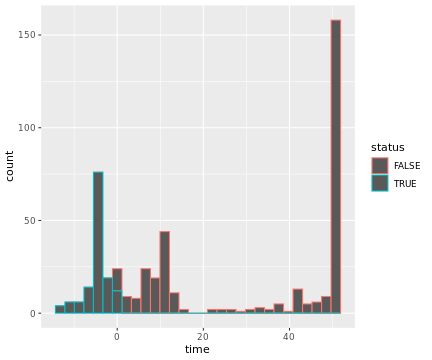

RObject{VecSxp}


In [740]:
R"
df %>%
    filter(
        DaysSinceDetection == 0,
        DaysSinceNegative <= 1,
        TestResult == 'Positive'
    ) %>% 
    transmute(PersonID, CumulativeInfectionNumber) %>%
    left_join(df) %>%
    group_by(PersonID, CumulativeInfectionNumber) %>%
    summarise({
        id = paste(PersonID, CumulativeInfectionNumber)[1]
        idx = which(!is.na(Symp_OnsetDate))[1]
        if(is.na(idx)) {
            time = last(DaysSinceDetection)
            status = FALSE
        } else {
            time = DaysSinceDetection[idx]
            status = TRUE
        }
        data.frame(id,time,status)
    }) -> surv
"

R"
surv %>%
    ggplot() +
    geom_histogram(aes(time, col=status))
"

In [786]:
R"
?ggsurvplot
"

RObject{StrSxp}


ggsurvplot              package:survminer              R Documentation

Drawing Survival Curves Using ggplot2

Description:

     ‘ggsurvplot’() is a generic function to plot survival curves.
     Wrapper around the ‘ggsurvplot_xx()’ family functions. Plot one or
     a list of survfit objects as generated by the survfit.formula()
     and surv_fit functions:

        • ggsurvplot_list()

        • ggsurvplot_facet()

        • ggsurvplot_group_by()

        • ggsurvplot_add_all()

        • ggsurvplot_combine()

     See the documentation for each function to learn how to control
     that aspect of the ggsurvplot().  ‘ggsurvplot’() accepts further
     arguments to be passed to the ‘ggsurvplot_xx()’ functions. Has
     options to:

        • plot a list of survfit objects,

        • facet survival curves into multiple panels,

        • group dataset by one or two grouping variables and to create
          the survival curves in each subset,

        • combine multiple ‘survfit’ obj

In [785]:
figsize(width=4, height=3)
R"
require(survival)
require(survminer)
ggsurvplot_df(
    survfit(Surv(time, status) ~ 1, data=surv),
    data = surv,
    risk.table = TRUE,
) -> g
"

LoadError: REvalError: Error in ggsurvplot_df(survfit(Surv(time, status) ~ 1, data = surv), data = surv,  : 
  fit should be a data frame.

┌ Warning: RCall.jl: `summarise()` has grouped output by 'PersonID'. You can override using the
│ `.groups` argument.
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


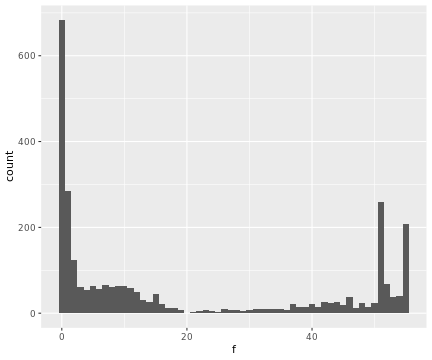

RObject{VecSxp}


In [663]:
R"
df %>%
    group_by(PersonID, CumulativeInfectionNumber) %>%
    summarise(
        f = n() - sum(!is.na(Symp_OnsetDate))
    ) %>%
    ggplot() +
    geom_histogram(aes(f), binwidth=1)
"

In [654]:
R"
unique(df$Symp_Ever)
"

RObject{StrSxp}
[1] "Unknown" "No"      "Yes"    


In [648]:
p = .33
p + (1-p)*(1-.8)

0.46399999999999997

In [637]:
GI = optimize(
    [0.0, 1e-3],
    [Inf, Inf],
    [1.0, 1.0],
    Fminbox(LBFGS())
) do p
    m,s = p
    d = LogNormal(m,s)
    sum(abs2, [
        median(d) - 7.9,
        mean(d) - 9.7,
        std(d) - 6.9
    ])
end

 * Status: success

 * Candidate solution
    Final objective value:     7.600930e-06

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 2.81e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.30e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 8.23e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    44
    ∇f(x) calls:   44


In [644]:
m1,s1 = IP.minimizer
m2,s2 = GI.minimizer
rho = .75
dist = MultivariateNormal([m1, m2], [s1^2 rho*s1*s2; rho*s1*s2 s2^2])

d = rand(dist, 10^4)'
sum(d[:,1] .< d[:,2]) / 10^4

0.8005

In [634]:
m1,s1 = IP.minimizer
m2,s2 = GI.minimizer
rho = -.9
dist = MultivariateNormal([m1, m2], [s1^2 rho*s1*s2; rho*s1*s2 s2^2])

d = exp.(rand(dist, 10^4)')
sum(d[:,1] .< d[:,2]) / 10^4

0.6234

┌ Warning: RCall.jl: Warning: Removed 1410 rows containing non-finite values (`stat_density2d()`).
└ @ RCall ~/.julia/packages/RCall/Wyd74/src/io.jl:172


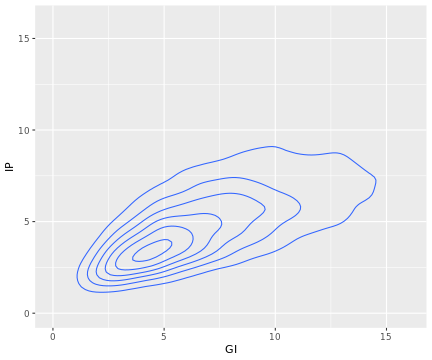

RObject{VecSxp}


In [675]:
R"
data.frame($(exp.(rand(dist, 10^4))')) %>%
    set_names(c('IP', 'GI')) %>%
    ggplot() +
    geom_density_2d(aes(GI, IP)) +
    lims(x=c(0,16), y=c(0,16))
"